In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [20]:
column_names = ["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "ConvexArea", "Extent", "Perimeter", "Class"]
ds = pd.read_csv('/content/drive/MyDrive/raisin/raisin.csv')
X = ds.drop(columns="Class")
y = ds["Class"]

In [21]:
# Initial dataset size
initial_rows, initial_cols = ds.shape

# Handle null values
null_values_count = ds.isnull().sum().sum()
if null_values_count > 0:
    print(f"{null_values_count} null values found in the dataset. Handling null values...")
    ds.dropna(inplace=True)
    print("Null values have been removed.")

# Handle duplicates
duplicates_count = ds.duplicated().sum()
if duplicates_count > 0:
    print(f"{duplicates_count} duplicate rows found in the dataset. Handling duplicates...")
    ds.drop_duplicates(inplace=True)
    print("Duplicate rows have been removed.")

In [22]:
# Updated dataset size
updated_rows, updated_cols = ds.shape

# Display basic information about the dataset after cleaning
print("\nDataset Information After Cleaning:")
print(ds.info())

# Display summary statistics of the dataset after cleaning
print("\nSummary Statistics After Cleaning:")
print(ds.describe())

# Summary of cleaning process
print("\nCleaning Summary:")
print(f"Initial Dataset Size: {initial_rows} rows, {initial_cols} columns")
print(f"Updated Dataset Size: {updated_rows} rows, {updated_cols} columns")
print(f"Rows Removed: {initial_rows - updated_rows}")
print(f"Columns Removed: {initial_cols - updated_cols}")


Dataset Information After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB
None

Summary Statistics After Cleaning:
                Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
count     900.000000       900.000000       900.000000    900.000000   
mean    87804.127778       430.929950       254.488133      0.781542   
std     39002.111390       116.035121        49.988902      0.090318   
min    

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


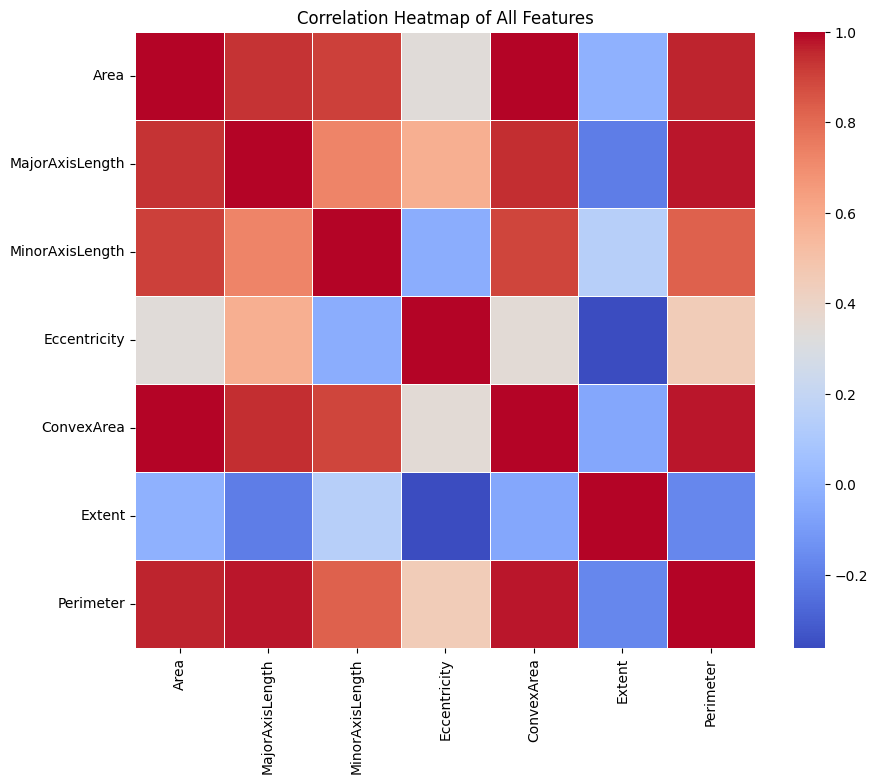

Eliminated Features:
Index([], dtype='object')

Selected Features:
Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter'],
      dtype='object')


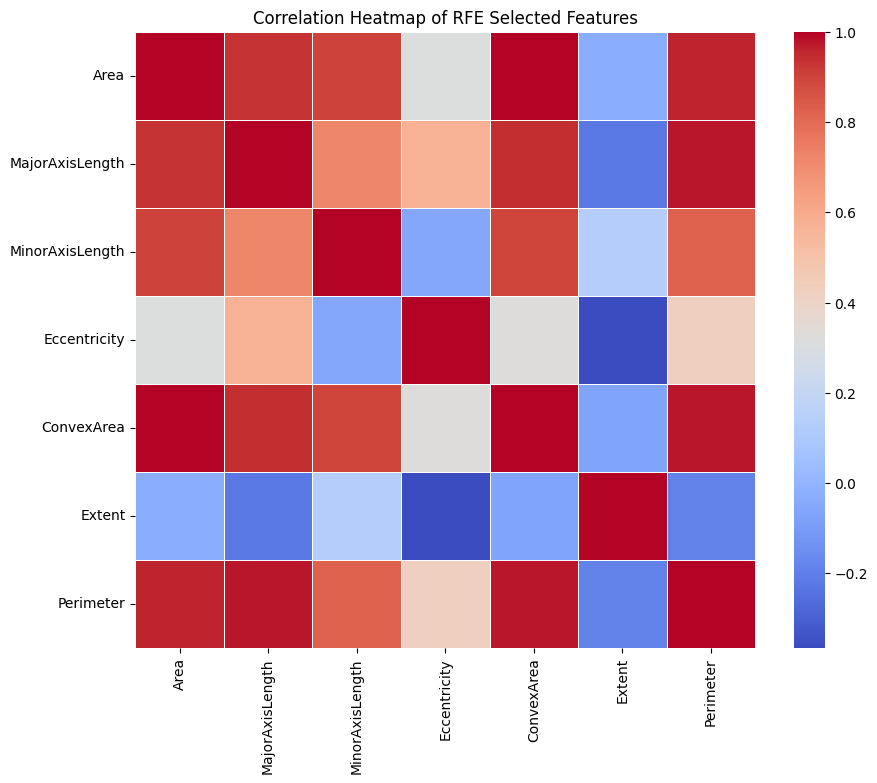

In [57]:
categorical_columns = X.select_dtypes(include=['object']).columns

# Use OneHotEncoder to transform categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_categorical_data = encoder.fit_transform(X[categorical_columns])

# Create DataFrame for encoded features
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and concatenate encoded columns
X = X.drop(columns=categorical_columns)
X = pd.concat([X, encoded_categorical_df], axis=1)

# Save the feature names after encoding
all_feature_names = X.columns

# Calculate correlation matrix for all features
corrmatall = X.corr()

# Plot correlation heatmap for all features
plt.figure(figsize=(10, 8))
sns.heatmap(corrmatall, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create RFE object and specify the number of features to select
rfe = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=10)

# Fit RFE to training data (excluding the target variable)
rfe.fit(X_train, y_train)

# Transform the training and testing data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Get the feature names of selected and eliminated features
selected_features = all_feature_names[rfe.support_]
eliminated_features = all_feature_names[~rfe.support_]

print("Eliminated Features:")
print(eliminated_features)

print("\nSelected Features:")
print(selected_features)

# Convert selected features to DataFrame with appropriate column names
df_selected_features = pd.DataFrame(X_train_selected, columns=selected_features)

# Calculate correlation matrix for selected features
correlation_matrix_selected = df_selected_features.corr()

# Plot correlation heatmap for selected features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of RFE Selected Features')
plt.show()

In [58]:
random_seed = 42
# Define models with random seed
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=random_seed),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(random_state=random_seed)
}

In [59]:
# Train and evaluate models with all features
results_all_features = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results_all_features[name] = accuracy

In [60]:
# Train and evaluate models with RFE-selected features
results_rfe_selected_features = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)
    results_rfe_selected_features[name] = accuracy

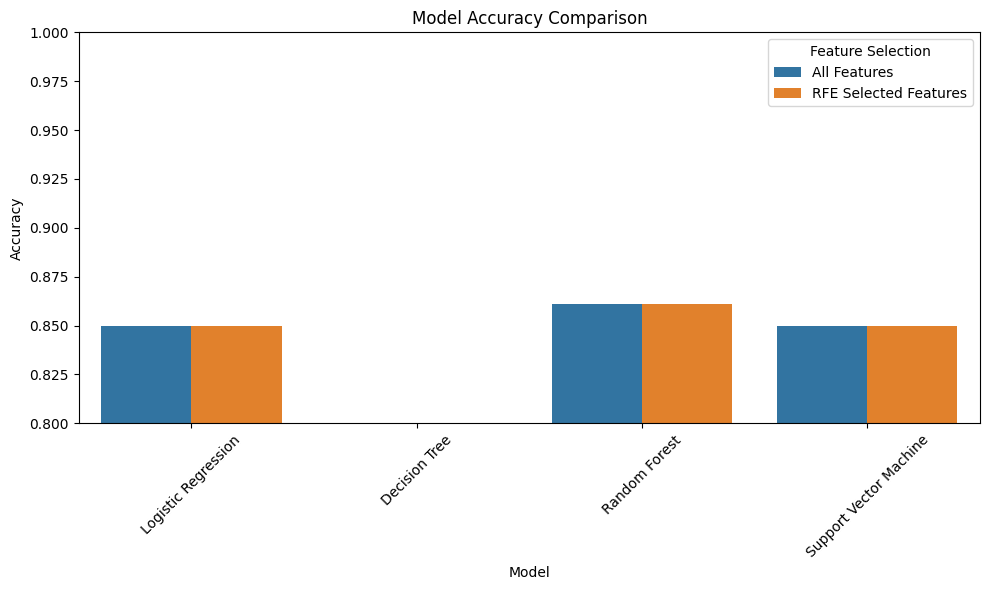

In [61]:
# Plotting
results_df = pd.DataFrame({
    "Model": list(results_all_features.keys()) + list(results_rfe_selected_features.keys()),
    "Accuracy": list(results_all_features.values()) + list(results_rfe_selected_features.values()),
    "Feature Selection": ['All Features'] * len(models) + ['RFE Selected Features'] * len(models)
})

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Feature Selection')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.legend(title='Feature Selection')
plt.tight_layout()
plt.show()

TRAIN AND EVALUATE

In [62]:
# Train and evaluate models with all features
results_all_features = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results_all_features[name] = accuracy

In [63]:
# Print scores before RFE
print("Scores with all features and without any added techniques:")
for name, accuracy in results_all_features.items():
    print(f"{name}: {accuracy*100:.2f}%")

Scores with all features and without any added techniques:
Logistic Regression: 85.00%
Decision Tree: 78.89%
Random Forest: 86.11%
Support Vector Machine: 85.00%


Train with RFE selected features

In [64]:
# Train and evaluate models with RFE-selected features
results_rfe_selected_features = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)
    results_rfe_selected_features[name] = accuracy

In [67]:
# Print scores after RFE
print("\nScores with RFE-selected features:")
for name, accuracy in results_rfe_selected_features.items():
    print(f"{name}: {accuracy*100:.2f}%")


Scores with RFE-selected features:
Logistic Regression: 85.00%
Decision Tree: 78.89%
Random Forest: 86.11%
Support Vector Machine: 85.00%


In [75]:
# Cross-validation using different models with selected features
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

cv_scores = {}

for model_name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train_selected, y_train, cv=5)
    cv_scores[model_name] = scores

    print(f"{model_name} Cross-Validation Scores: {scores}")
    print(f"{model_name} Mean Cross-Validation Score: {np.mean(scores)}\n")

Logistic Regression Cross-Validation Scores: [0.86805556 0.84027778 0.8125     0.83333333 0.91666667]
Logistic Regression Mean Cross-Validation Score: 0.8541666666666667

Decision Tree Cross-Validation Scores: [0.83333333 0.8125     0.86805556 0.82638889 0.84027778]
Decision Tree Mean Cross-Validation Score: 0.8361111111111112

Random Forest Cross-Validation Scores: [0.83333333 0.84027778 0.89583333 0.80555556 0.88194444]
Random Forest Mean Cross-Validation Score: 0.851388888888889

Support Vector Machine Cross-Validation Scores: [0.84027778 0.77777778 0.81944444 0.77777778 0.84027778]
Support Vector Machine Mean Cross-Validation Score: 0.8111111111111111



PLOT CROSS VALIDATION SCORES

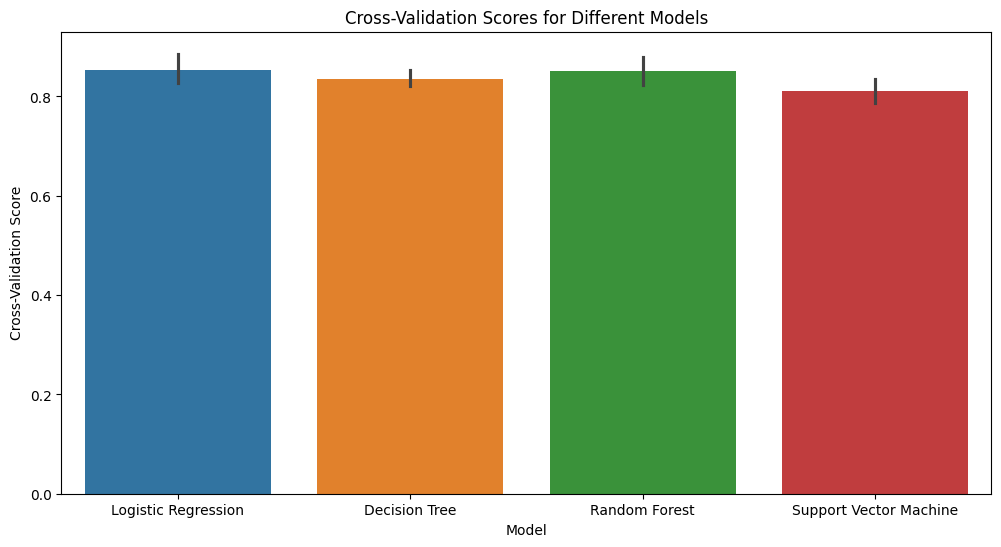

In [77]:
# Plot the cross-validation scores
plt.figure(figsize=(12, 6))
sns.barplot(data=pd.DataFrame(cv_scores))
plt.title('Cross-Validation Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('Cross-Validation Score')
plt.show()